In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding,LSTM,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization

from keras.optimizers import SGD, RMSprop, Adam

from sklearn.preprocessing import MinMaxScaler
import math

import cPickle as pickle

from keras.callbacks import RemoteMonitor

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
base_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/dmc/deep-learning-time-series-analysis/"
resources_folder = "resources/"

In [3]:
data = pd.read_csv('../data/train.csv', sep='|')
data['itemsPurchased'] = (data['revenue'] / data['price']).astype(int)
data['purchase'] = data['itemsPurchased'].apply(lambda x: 1 if x >= 1 else int(x))
data

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,itemsPurchased,purchase
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00,0,0
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00,0,0
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00,0,0
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55,1,1
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14,1,1
5,6,1,3661,0,1,13.66,0,0,1,10.03,10.03,1,1
6,7,1,3856,1,1,3.03,0,0,1,3.58,3.58,1,1
7,8,1,16963,0,1,8.78,1,0,0,8.75,0.00,0,0
8,9,1,14560,0,1,10.84,1,0,0,12.04,0.00,0,0
9,10,1,4853,1,1,9.12,1,0,0,8.75,0.00,0,0


In [4]:
data = data[['day','itemsPurchased']]
data

,day,itemsPurchased
0,1,0
1,1,0
2,1,0
3,1,1
4,1,1
5,1,1
6,1,1
7,1,0
8,1,0
9,1,0


In [108]:
grouped_by_day = data.groupby('day', as_index=False).sum()['itemsPurchased']
grouped_by_day_df = pd.DataFrame(grouped_by_day)
grouped_by_day_df['day'] = pd.Series(range(1,93))
grouped_by_day_df

,itemsPurchased,day
0,8736,1
1,8292,2
2,13235,3
3,13202,4
4,13066,5
5,13132,6
6,9934,7
7,8347,8
8,6869,9
9,12368,10


In [109]:
grouped_by_day_df.to_csv('../data/count-by-day.csv')

In [31]:
raw_dataset = dataframe.values.astype('float32')
raw_dataset.shape

(92,)

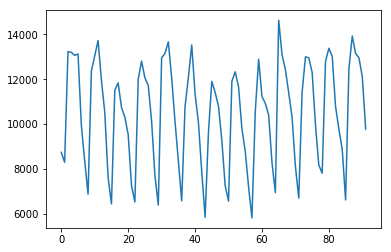

In [33]:
plt.plot(raw_dataset)
plt.show()

In [34]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(raw_dataset)

/opt/conda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/opt/conda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


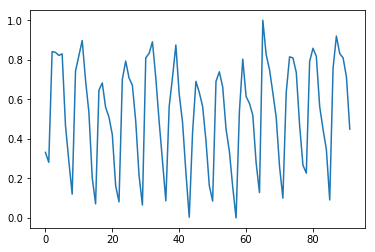

In [35]:
plt.plot(dataset)
plt.show()

In [36]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

(61, 31)


In [37]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [76]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(testX.shape)

(59, 1)
(29, 1)


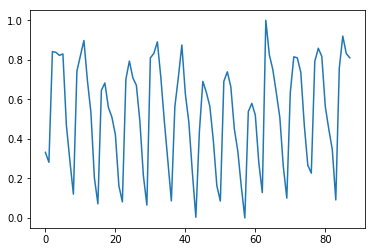

In [77]:
plt.plot(np.concatenate([trainX,testX]))
plt.show()

In [78]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(59, 1, 1)
(29, 1, 1)


In [41]:
model = Sequential()
model.add(BatchNormalization(input_shape=(1,1)))
model.add(LSTM(1024))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = Adam(0.001))

In [86]:
model.fit(trainX, trainY, 
          nb_epoch=1000, 
          batch_size=64, 
          verbose=2)

Epoch 1/1000
0s - loss: 0.0198
Epoch 2/1000
0s - loss: 0.0198
Epoch 3/1000
0s - loss: 0.0198
Epoch 4/1000
0s - loss: 0.0198
Epoch 5/1000
0s - loss: 0.0198
Epoch 6/1000
0s - loss: 0.0198
Epoch 7/1000
0s - loss: 0.0198
Epoch 8/1000
0s - loss: 0.0198
Epoch 9/1000
0s - loss: 0.0198
Epoch 10/1000
0s - loss: 0.0198
Epoch 11/1000
0s - loss: 0.0198
Epoch 12/1000
0s - loss: 0.0198
Epoch 13/1000
0s - loss: 0.0198
Epoch 14/1000
0s - loss: 0.0198
Epoch 15/1000
0s - loss: 0.0198
Epoch 16/1000
0s - loss: 0.0198
Epoch 17/1000
0s - loss: 0.0198
Epoch 18/1000
0s - loss: 0.0198
Epoch 19/1000
0s - loss: 0.0198
Epoch 20/1000
0s - loss: 0.0198
Epoch 21/1000
0s - loss: 0.0198
Epoch 22/1000
0s - loss: 0.0198
Epoch 23/1000
0s - loss: 0.0198
Epoch 24/1000
0s - loss: 0.0198
Epoch 25/1000
0s - loss: 0.0197
Epoch 26/1000
0s - loss: 0.0197
Epoch 27/1000
0s - loss: 0.0197
Epoch 28/1000
0s - loss: 0.0197
Epoch 29/1000
0s - loss: 0.0197
Epoch 30/1000
0s - loss: 0.0197
Epoch 31/1000
0s - loss: 0.0197
Epoch 32/1000
0s 

In [87]:
train_error = model.evaluate(trainX,trainY)
test_error = model.evaluate(testX,testY)
print("Train error = %f"%train_error)
print("Test error = %f"%test_error)

29/29 [==============================] - 0sA: 0s
Train error = 0.019465
Test error = 0.041460


In [88]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [89]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
# inverse_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
# inverse_testY = scaler.inverse_transform([testY])

In [90]:
# shift train predictions for plotting
trainPredictPlot = np.expand_dims(np.empty_like(dataset),axis=1)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict

In [91]:
# shift test predictions for plotting
testPredictPlot = np.expand_dims(np.empty_like(dataset),axis=1)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict

/opt/conda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


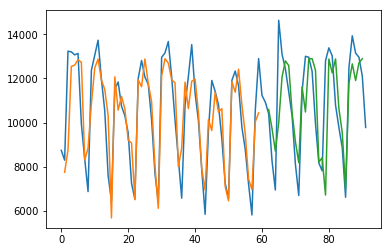

In [92]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [110]:
LSTM??